<a href="https://colab.research.google.com/github/vicentcamison/idal_ia3/blob/main/3%20Aprendizaje%20profundo%20(II)/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Subset
from torch import nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split

import glob

We are going to create a GAN to generate new fonts

In [2]:
# Access to the BOB ROSS images folder
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
#directory = "gdrive/MyDrive/UNIVERSIDAD/Master Propio IA UV/3 Aprendizaje profundo (II)/Datasets/Bob Ross/train"
directory = "gdrive/MyDrive/UNIVERSIDAD/Master Propio IA UV/3 Aprendizaje profundo (II)/Trabajo final/fonts"

In [43]:
# get data file names (this code takes a while to retrieve all data and prepare all dataframes)
filenames = glob.glob(directory + "/*.csv")
dfs = [pd.read_csv(filename) for filename in filenames]

In [44]:
len(dfs)

153

In [ ]:
# Characters have an index associated to them (m_label). The index is related to the character in the following dictionary
index_to_char = {65:'A', 66:'B', 67:'C', 68:'D', 69:'E', 70:'F', 71:'G', 72:'H', 73:'I', 74:'J',
                 75:'K', 76:'L', 77:'M', 78:'N', 79:'O', 80:'P', 81:'Q', 82:'R', 83:'S', 84:'T',
                 85:'U', 86:'V', 87:'W', 88:'X', 89:'Y', 90:'Z', 97:'a', 98:'b', 99:'c', 100:'d',
                 101:'e', 102:'f', 103:'g', 104:'h', 105:'i', 106:'j', 107:'k', 108:'l', 109:'m',
                 110:'n', 111:'o', 112:'p', 113:'q', 114:'r', 115:'s', 116:'t', 117:'u', 118:'v',
                 119:'w', 120:'x', 121:'y', 122:'z', 48:'0', 49:'1', 50:'2', 51:'3', 52:'4', 53:'5',
                 54:'6', 55:'7', 56:'8', 57:'9'}

In [ ]:
number_min = 48
number_max = 57
upper_min = 65
upper_max = 90
lower_min = 97
lower_max = 122

In [ ]:
# We create the datasets. We are going to divide them in NUMBERS, UPPERCASE LETTERS and LOWERCASE LETTERS
X_numbers = []
X_upper = []
X_lower = []
Y_numbers = []
Y_upper = []
Y_lower = []

for df in dfs:
  #df = df[np.logical_and(df.loc[:,'strength'] < 0.5, df.loc[:,'italic'] == 0]
  df_straight = df[np.logical_and(df.loc[:,'strength'] < 0.5, df.loc[:,'italic'] == 0)] #remove the columns that are in bold or cursive
  # We get the elements of the dataframe that reference the images of characters (upper and lower letters, and numbers)
  X_numbers_new = df_straight[np.logical_and(df_straight.loc[:,'m_label'] >= number_min, df_straight.loc[:, 'm_label'] <= number_max)].iloc[:, 12:]
  X_upper_new = df_straight[np.logical_and(df_straight.loc[:,'m_label'] >= upper_min, df_straight.loc[:, 'm_label'] <= upper_max)].iloc[:, 12:]
  X_lower_new = df_straight[np.logical_and(df_straight.loc[:,'m_label'] >= lower_min, df_straight.loc[:, 'm_label'] <= lower_max)].iloc[:, 12:]
  for row in df[np.logical_and(df.loc[:,'strength'] < 0.5, df.loc[:,'italic'] == 0].iterrows():
    if row.strength < 0.5 and row.italic == 0:

In [41]:
font_db = pd.read_csv(directory+'/AGENCY.csv')
font_db

,font,fontVariant,m_label,strength,italic,orientation,m_top,m_left,originalH,originalW,h,w,r0c0,r0c1,r0c2,r0c3,r0c4,r0c5,r0c6,r0c7,r0c8,r0c9,r0c10,r0c11,r0c12,r0c13,r0c14,r0c15,r0c16,r0c17,r0c18,r0c19,r1c0,r1c1,r1c2,r1c3,r1c4,r1c5,r1c6,r1c7,...,r18c0,r18c1,r18c2,r18c3,r18c4,r18c5,r18c6,r18c7,r18c8,r18c9,r18c10,r18c11,r18c12,r18c13,r18c14,r18c15,r18c16,r18c17,r18c18,r18c19,r19c0,r19c1,r19c2,r19c3,r19c4,r19c5,r19c6,r19c7,r19c8,r19c9,r19c10,r19c11,r19c12,r19c13,r19c14,r19c15,r19c16,r19c17,r19c18,r19c19
0,AGENCY,AGENCY FB,64258,0.4,0,0.0,35,21,51,22,20,20,1,1,1,21,101,210,255,255,255,255,255,255,255,255,255,255,255,255,255,255,1,1,1,93,255,255,255,176,...,1,1,1,93,255,255,255,70,1,1,1,1,1,1,1,1,163,255,255,255,1,1,1,93,255,255,255,70,1,1,1,1,1,1,1,1,163,255,255,255
1,AGENCY,AGENCY FB,64257,0.4,0,0.0,35,21,51,22,20,20,1,1,1,21,101,210,255,255,255,255,255,255,255,255,255,255,255,255,174,65,1,1,1,93,255,255,255,176,...,1,1,1,93,255,255,255,70,1,1,1,1,1,1,1,1,163,255,255,255,1,1,1,93,255,255,255,70,1,1,1,1,1,1,1,1,163,255,255,255
2,AGENCY,AGENCY FB,61442,0.4,0,0.0,35,21,51,22,20,20,1,1,1,21,101,210,255,255,255,255,255,255,255,255,255,255,255,255,255,255,1,1,1,93,255,255,255,176,...,1,1,1,93,255,255,255,70,1,1,1,1,1,1,1,1,163,255,255,255,1,1,1,93,255,255,255,70,1,1,1,1,1,1,1,1,163,255,255,255
3,AGENCY,AGENCY FB,61441,0.4,0,0.0,35,21,51,22,20,20,1,1,1,21,101,210,255,255,255,255,255,255,255,255,255,255,255,255,174,65,1,1,1,93,255,255,255,176,...,1,1,1,93,255,255,255,70,1,1,1,1,1,1,1,1,163,255,255,255,1,1,1,93,255,255,255,70,1,1,1,1,1,1,1,1,163,255,255,255
4,AGENCY,AGENCY FB,9674,0.4,0,0.0,51,21,33,25,20,20,1,1,1,1,1,1,1,1,132,255,255,132,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,38,...,1,1,1,1,1,1,1,38,255,255,255,255,38,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,132,255,255,132,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999,AGENCY,AGENCY FB,37,0.7,1,0.0,35,27,51,48,20,20,1,1,1,1,1,91,231,255,255,255,255,129,1,1,1,1,1,36,222,233,1,1,1,1,5,237,252,154,...,8,199,225,41,1,1,1,1,125,255,237,146,146,219,255,46,1,1,1,1,168,222,36,1,1,1,1,1,129,255,255,255,255,231,114,1,1,1,1,1
1000,AGENCY,AGENCY FB,36,0.7,1,0.0,30,24,61,40,20,20,1,1,1,1,1,1,1,1,1,1,1,1,86,255,255,255,255,84,1,1,1,1,1,1,1,1,1,1,...,51,92,92,214,255,255,255,255,92,92,92,51,1,1,1,1,1,1,1,1,1,1,42,255,255,255,255,130,1,1,1,1,1,1,1,1,1,1,1,1
1001,AGENCY,AGENCY FB,35,0.7,1,0.0,35,25,51,44,20,20,1,1,1,1,1,1,1,1,1,1,6,183,255,255,115,1,72,255,255,231,1,1,1,1,1,1,1,1,...,43,252,255,239,24,5,175,255,255,124,1,1,1,1,1,1,1,1,1,1,185,255,255,117,1,69,255,255,219,15,1,1,1,1,1,1,1,1,1,1
1002,AGENCY,AGENCY FB,34,0.7,1,0.0,35,35,16,21,20,20,1,1,1,49,255,255,255,255,255,255,122,1,1,171,255,255,255,255,255,255,1,1,1,49,255,255,255,255,...,73,255,255,255,195,1,1,1,1,31,164,255,255,255,73,1,1,1,1,1,255,255,255,255,195,1,1,1,1,122,255,255,255,255,73,1,1,1,1,1


In [22]:
#chars = []
for index, row in font_db.iterrows():
  #chars[index] = row.iloc[12:]
  chars = row.iloc[12:]
  print(chars)
  #chars[index] = np.array(chars[index]).reshape((20,20))
  chars = np.reshape(row.iloc[12:].values, (20,20))

Se han truncado las últimas 5000 líneas del flujo de salida.
r0c4      255
         ... 
r19c15    255
r19c16    255
r19c17    255
r19c18    161
r19c19     34
Name: 587, Length: 400, dtype: object
r0c0       44
r0c1      157
r0c2      255
r0c3      255
r0c4      255
         ... 
r19c15    255
r19c16    168
r19c17     21
r19c18      1
r19c19      1
Name: 588, Length: 400, dtype: object
r0c0       44
r0c1      233
r0c2      255
r0c3      255
r0c4      255
         ... 
r19c15    255
r19c16    255
r19c17    255
r19c18    233
r19c19     44
Name: 589, Length: 400, dtype: object
r0c0        1
r0c1        1
r0c2        7
r0c3       63
r0c4      175
         ... 
r19c15    255
r19c16    255
r19c17    255
r19c18    255
r19c19    255
Name: 590, Length: 400, dtype: object
r0c0        1
r0c1       25
r0c2      255
r0c3      255
r0c4      255
         ... 
r19c15    255
r19c16    255
r19c17    255
r19c18    255
r19c19    255
Name: 591, Length: 400, dtype: object
r0c0        1
r0c1        2
r0c2   

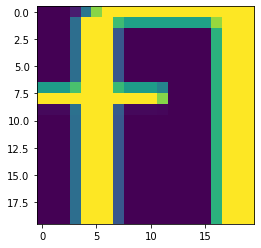

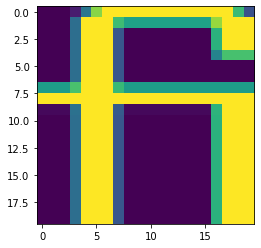

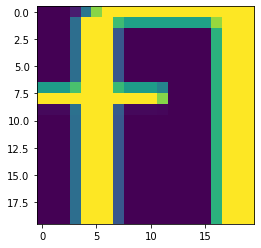

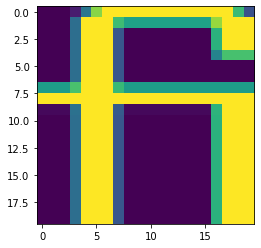

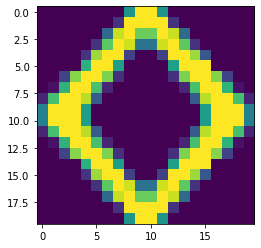

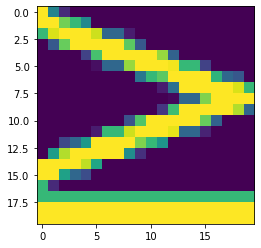

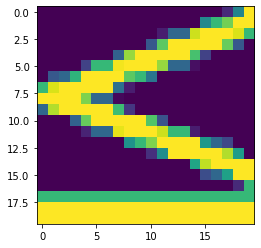

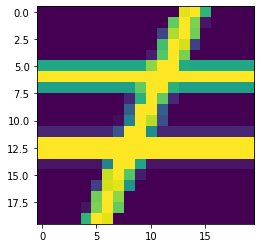

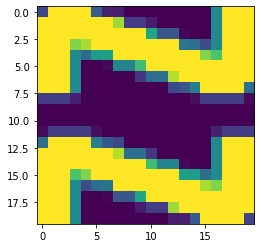

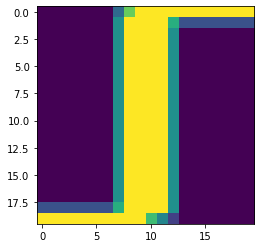

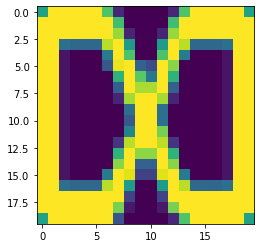

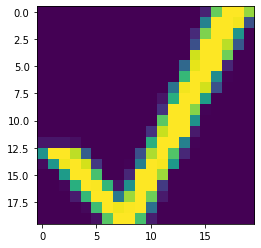

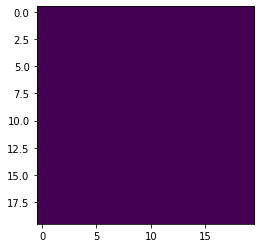

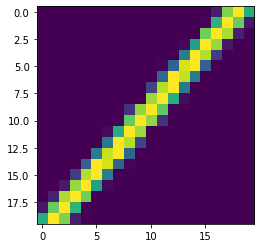

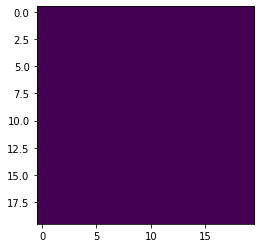

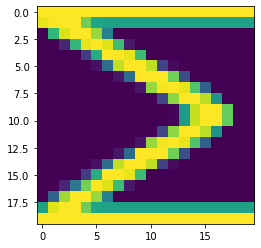

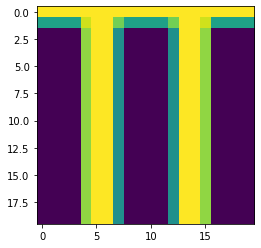

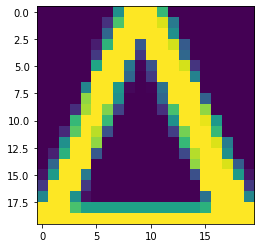

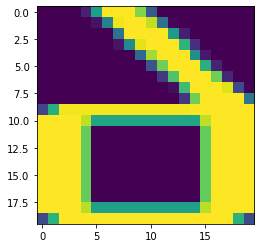

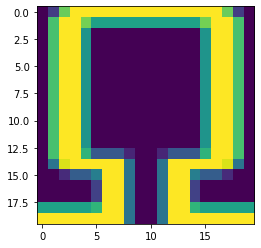

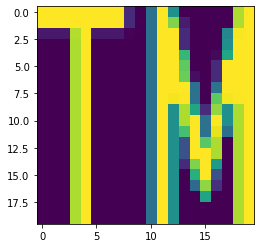

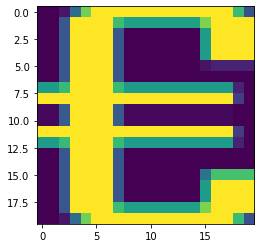

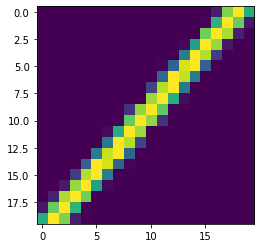

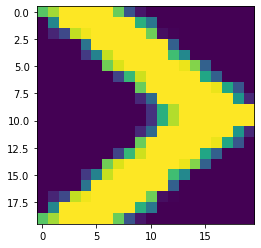

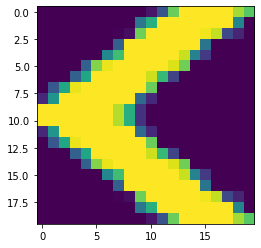

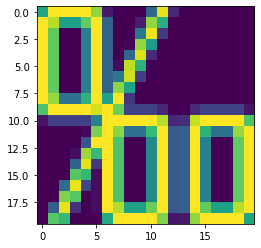

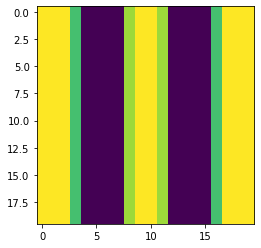

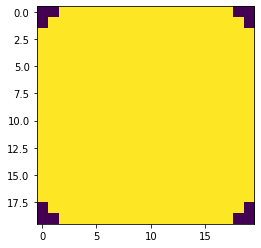

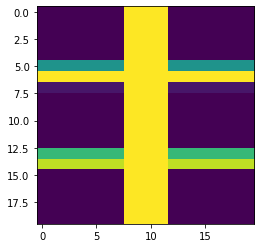

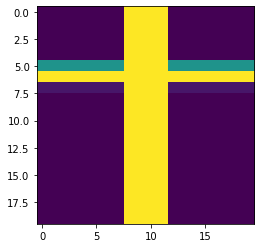

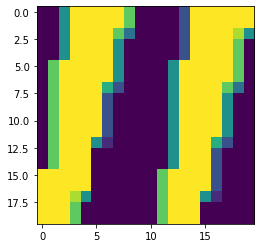

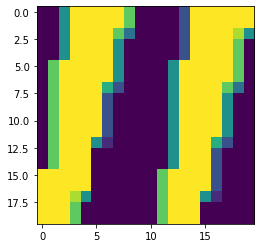

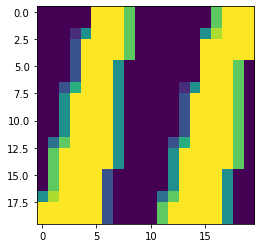

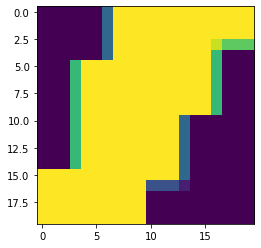

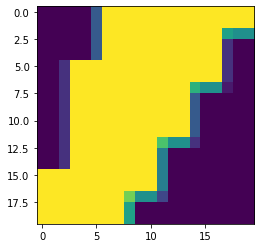

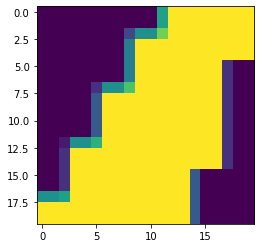

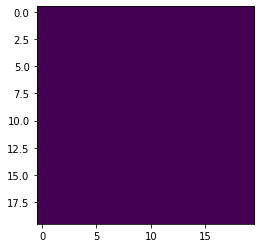

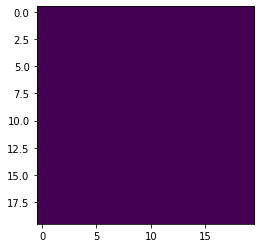

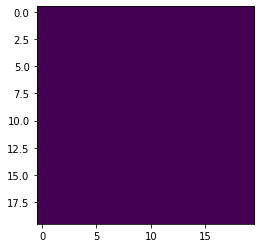

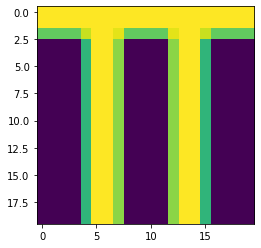

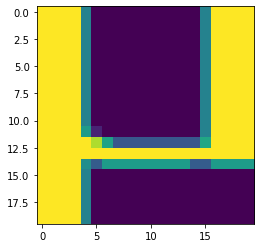

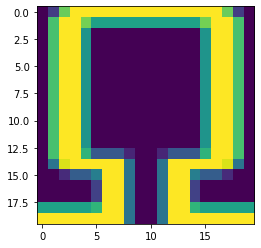

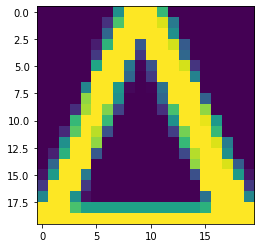

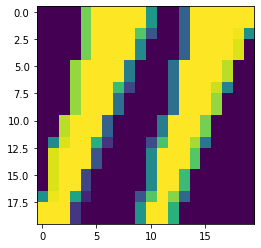

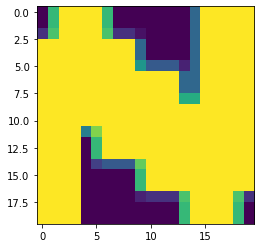

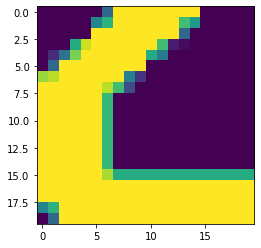

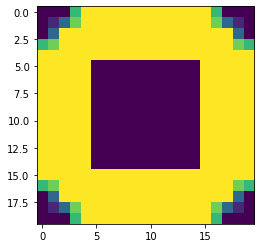

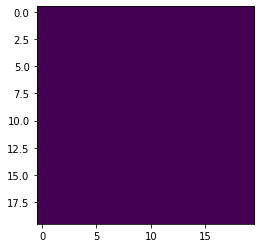

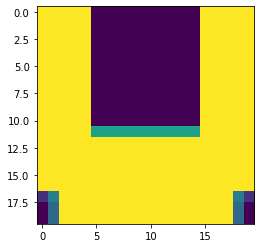

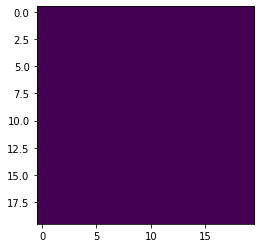

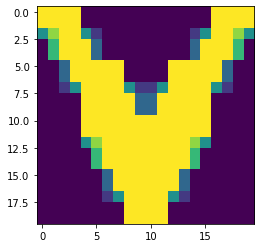

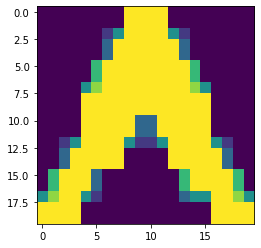

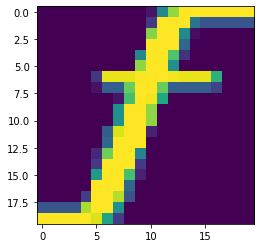

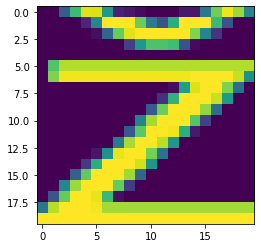

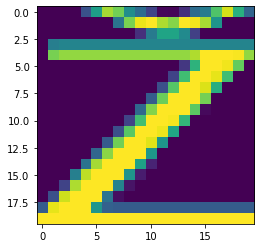

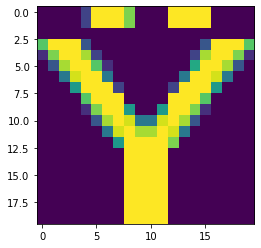

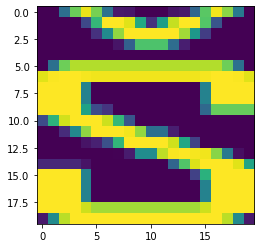

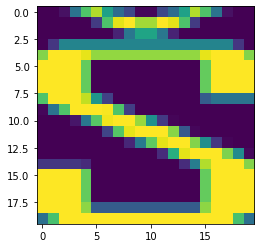

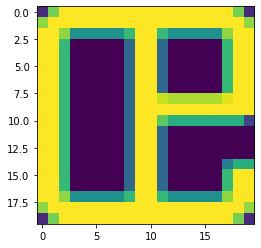

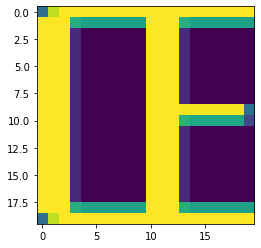

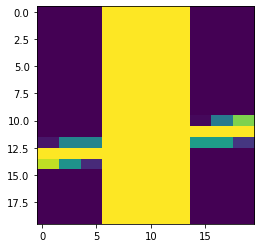

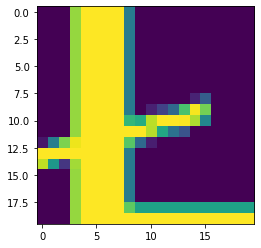

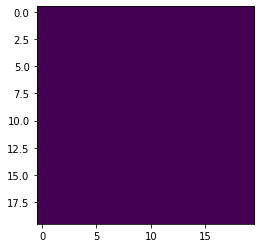

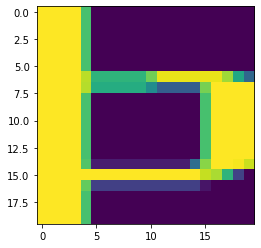

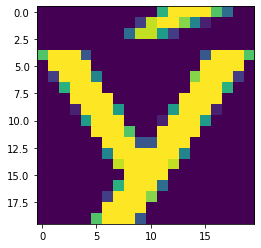

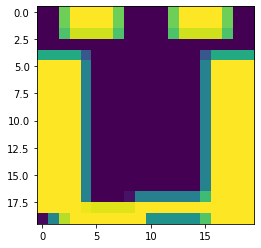

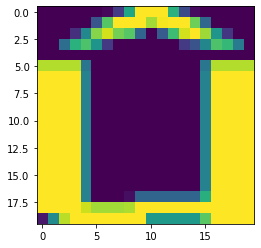

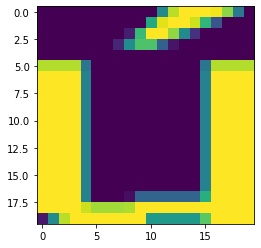

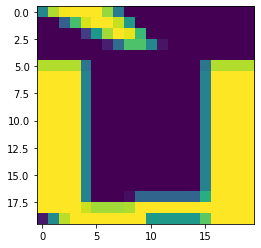

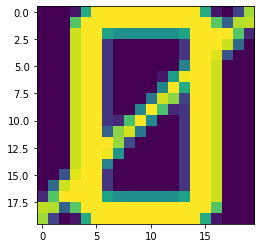

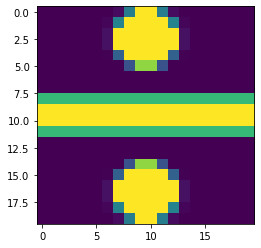

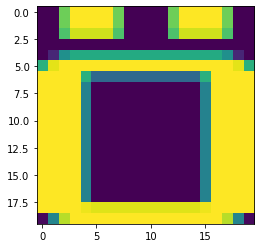

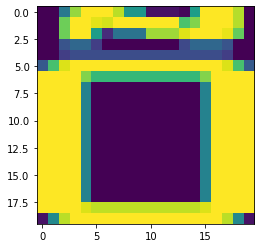

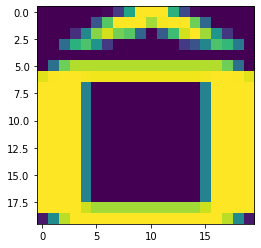

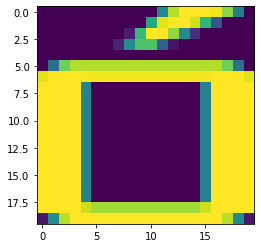

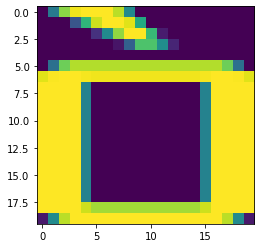

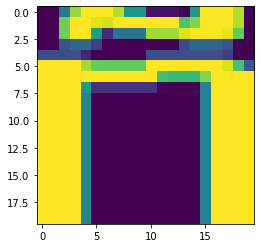

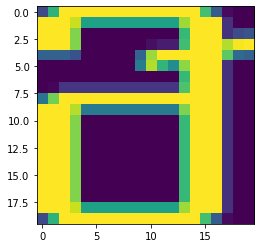

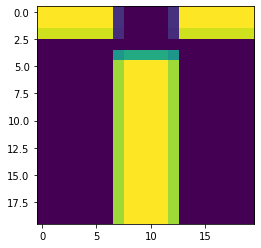

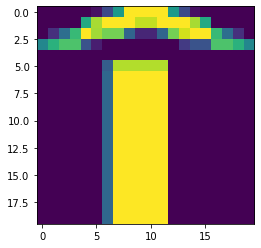

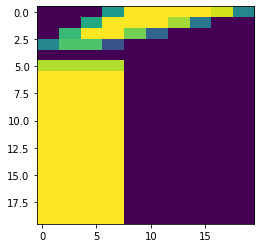

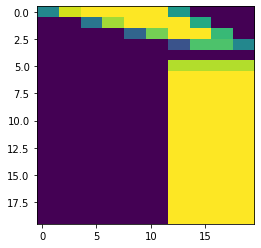

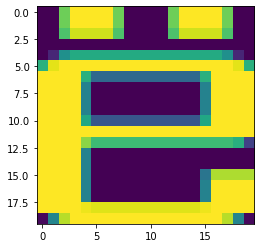

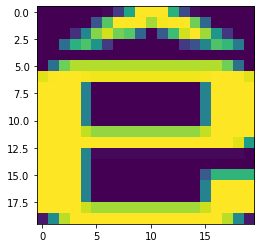

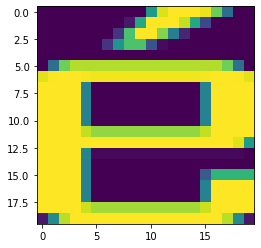

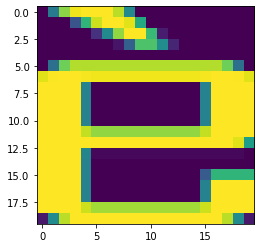

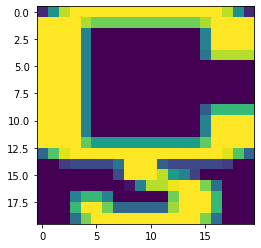

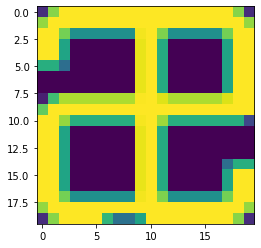

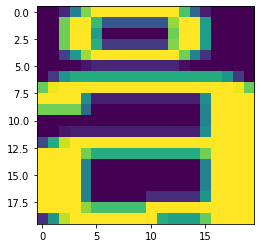

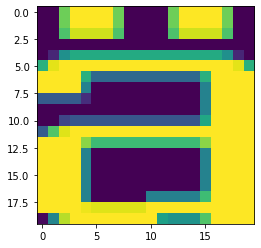

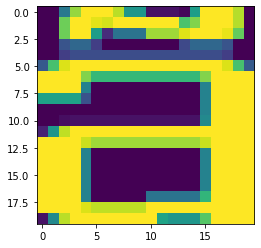

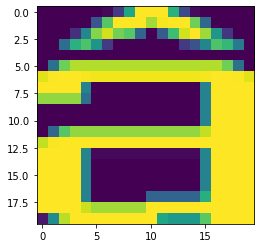

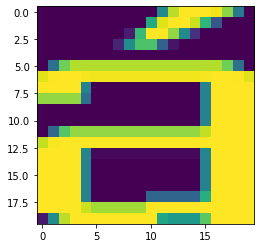

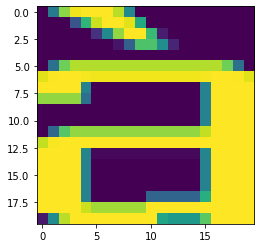

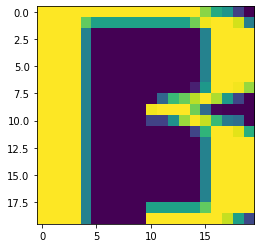

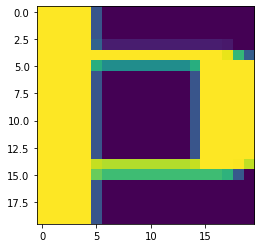

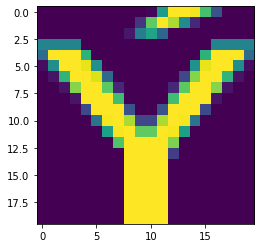

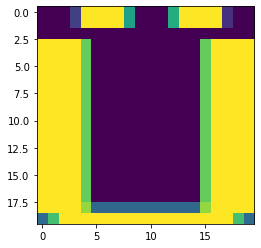

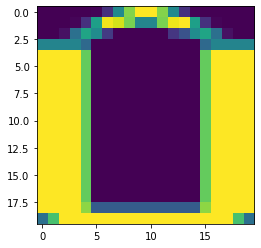

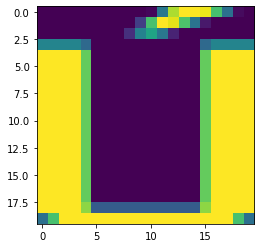

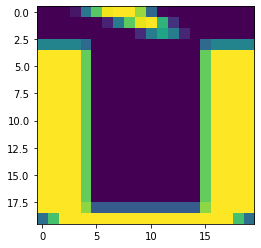

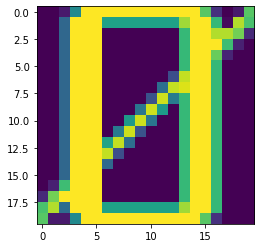

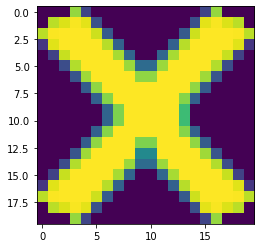

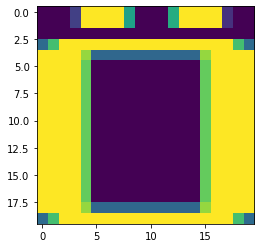

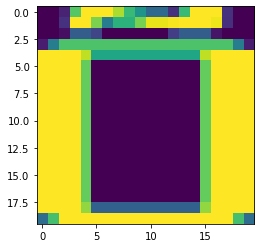

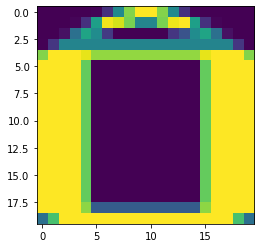

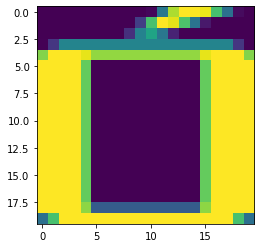

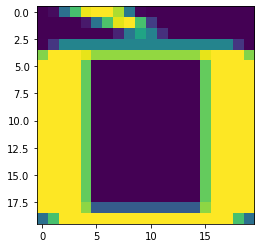

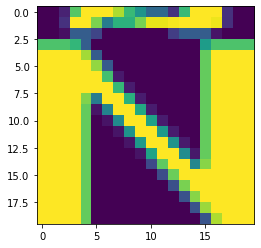

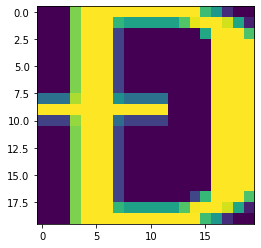

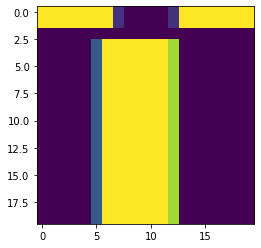

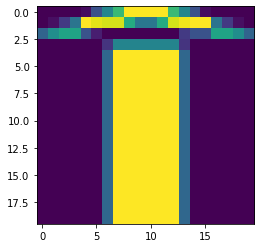

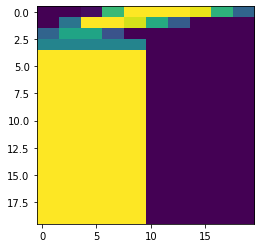

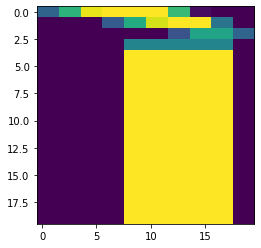

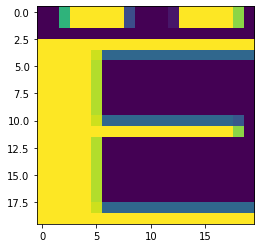

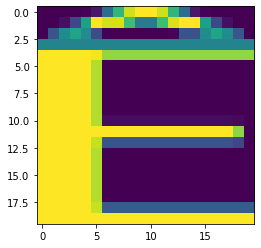

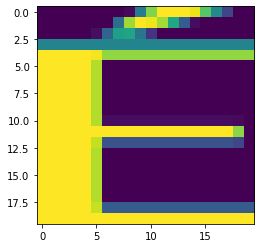

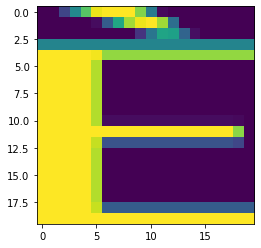

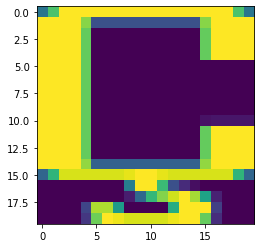

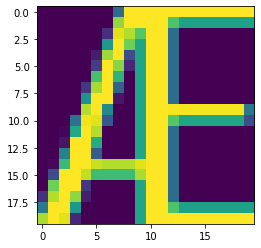

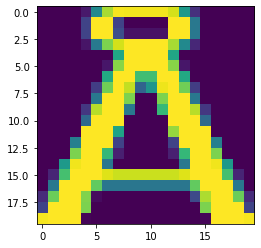

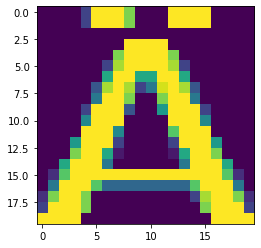

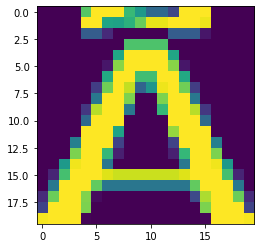

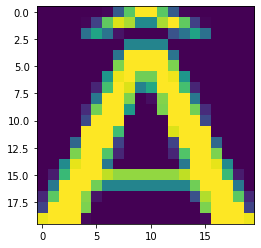

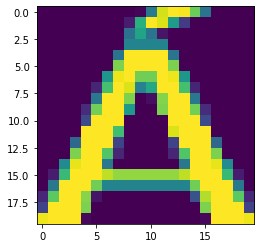

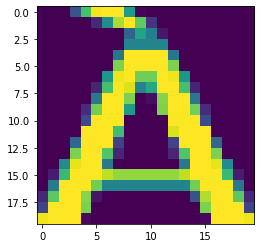

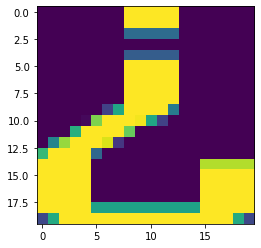

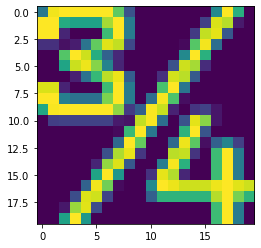

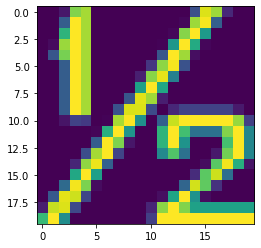

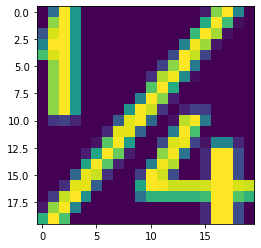

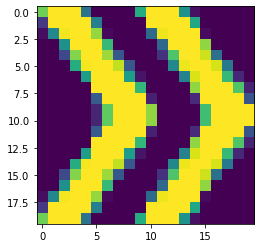

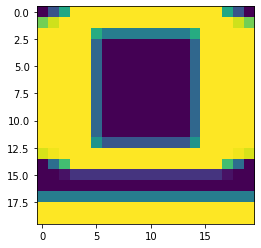

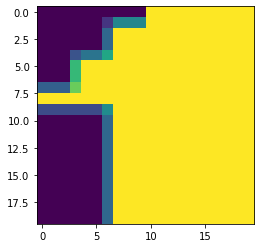

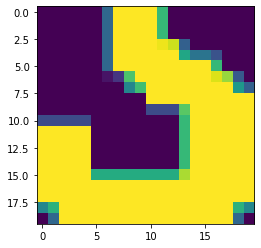

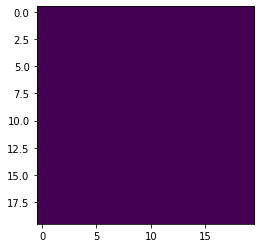

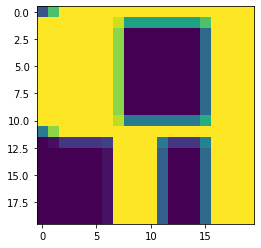

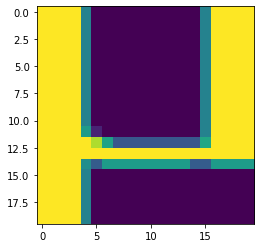

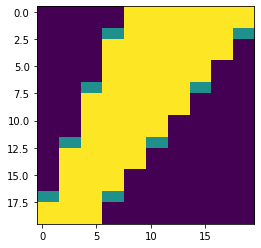

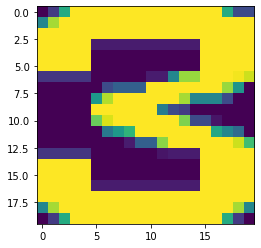

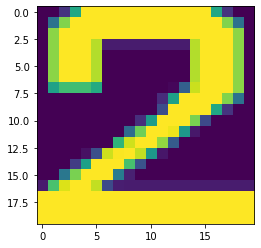

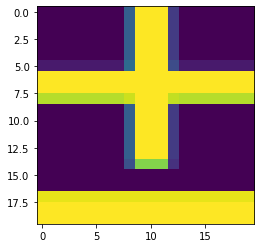

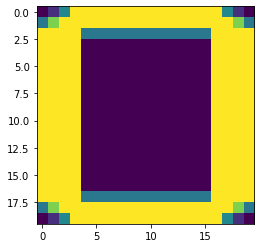

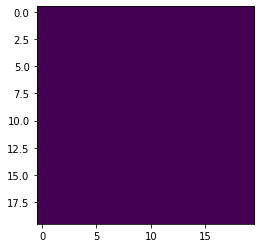

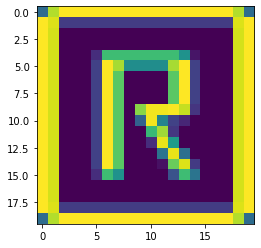

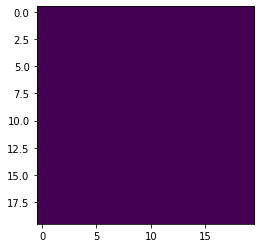

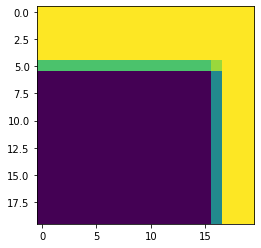

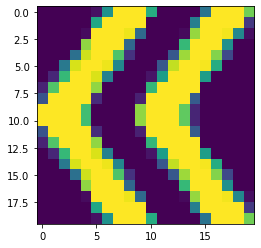

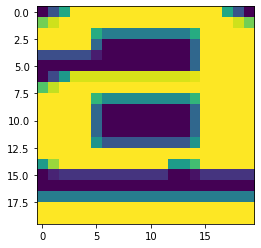

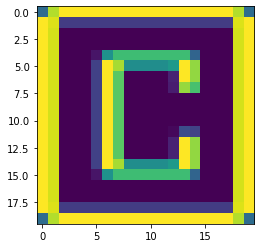

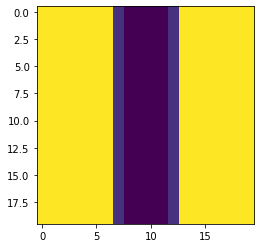

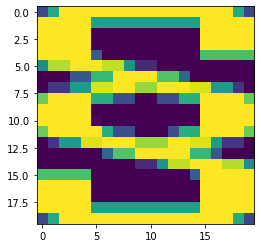

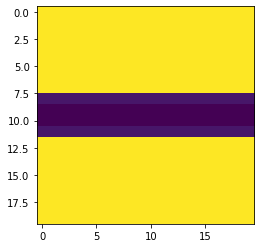

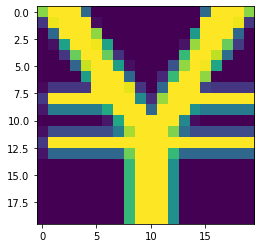

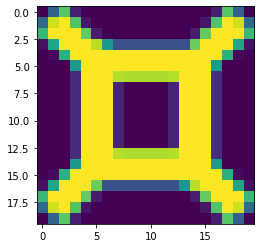

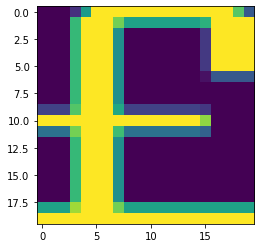

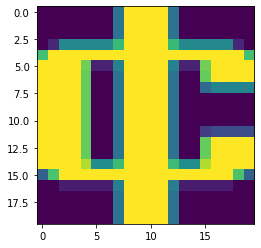

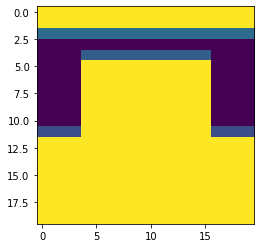

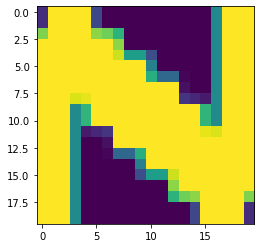

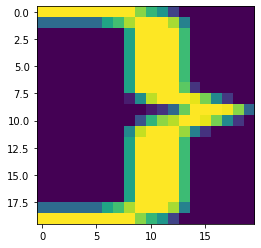

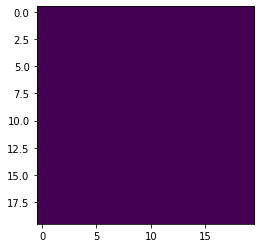

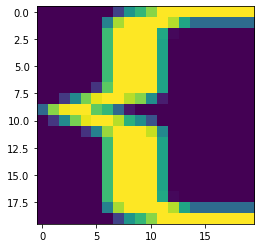

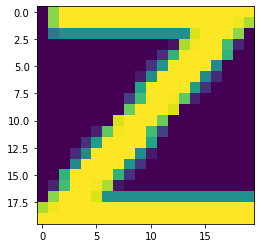

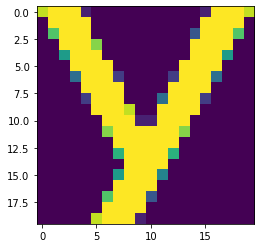

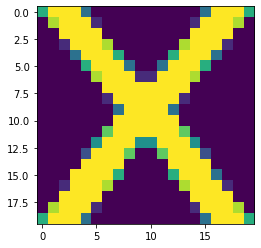

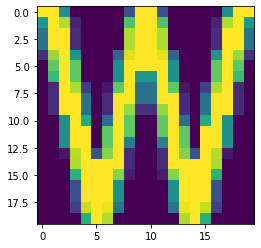

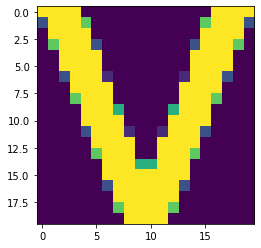

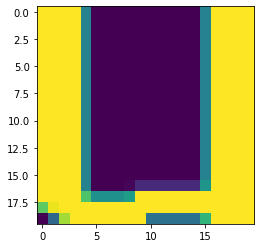

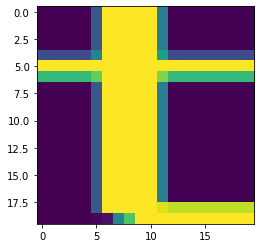

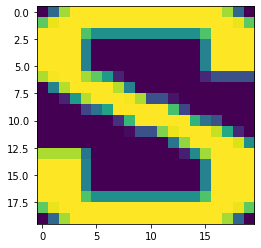

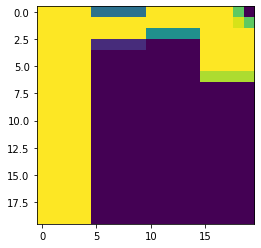

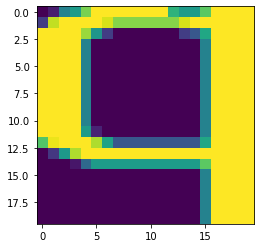

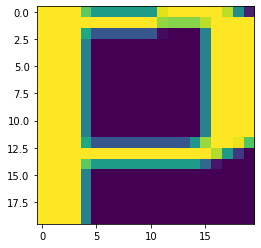

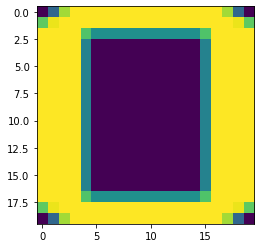

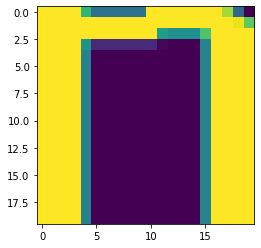

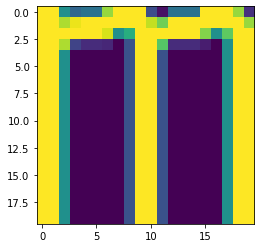

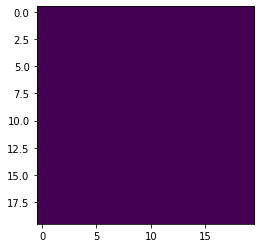

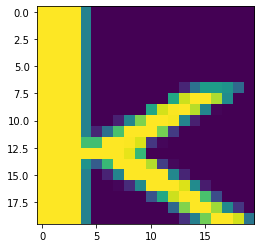

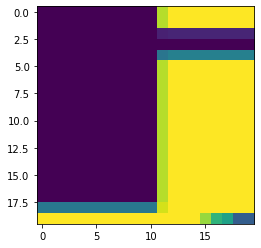

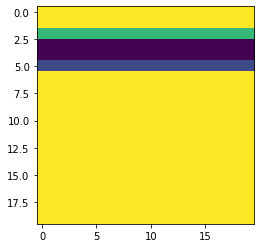

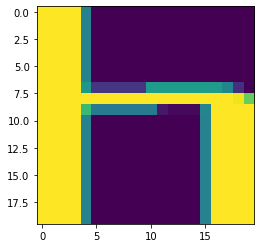

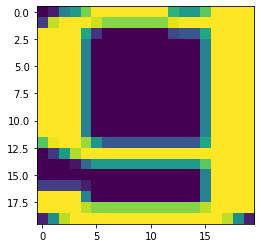

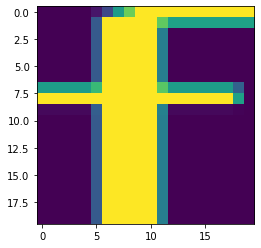

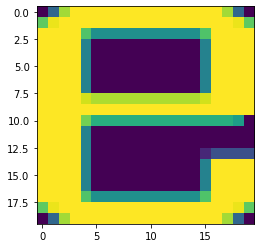

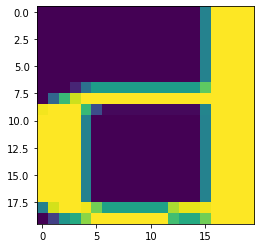

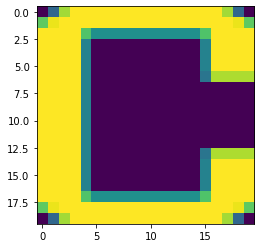

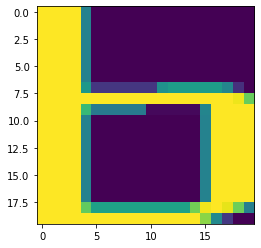

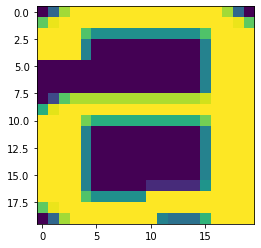

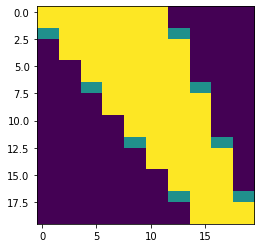

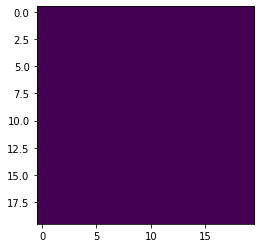

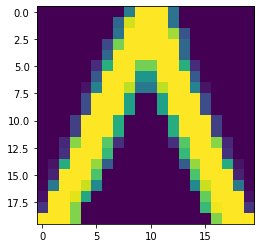

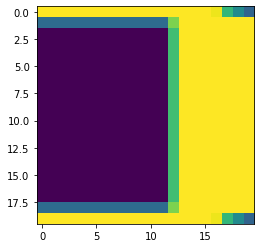

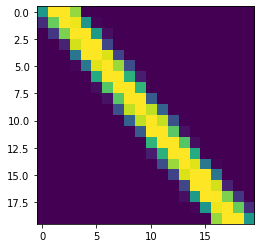

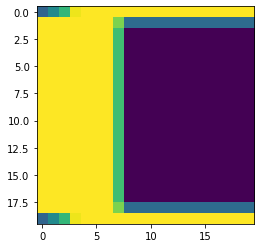

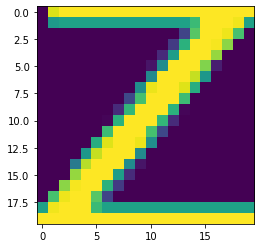

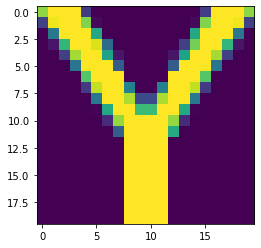

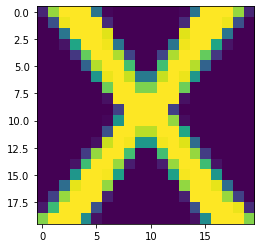

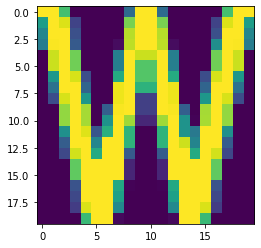

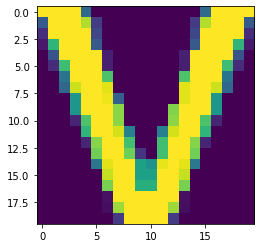

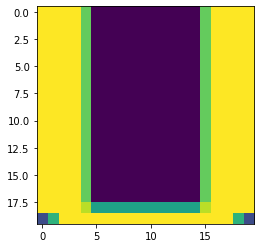

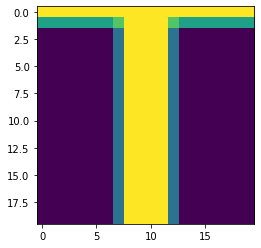

In [39]:
for i in range(200):
  chars = font_db.iloc[i, 12:]
  chars2 = np.array(chars)
  chars3 = np.reshape(chars2, newshape=(20,20))
  plt.figure()
  plt.imshow(chars3.astype(float))
  plt.show()

In [54]:
chars = font_db[char_37]
chars

,font,fontVariant,m_label,strength,italic,orientation,m_top,m_left,originalH,originalW,h,w,r0c0,r0c1,r0c2,r0c3,r0c4,r0c5,r0c6,r0c7,r0c8,r0c9,r0c10,r0c11,r0c12,r0c13,r0c14,r0c15,r0c16,r0c17,r0c18,r0c19,r1c0,r1c1,r1c2,r1c3,r1c4,r1c5,r1c6,r1c7,...,r18c0,r18c1,r18c2,r18c3,r18c4,r18c5,r18c6,r18c7,r18c8,r18c9,r18c10,r18c11,r18c12,r18c13,r18c14,r18c15,r18c16,r18c17,r18c18,r18c19,r19c0,r19c1,r19c2,r19c3,r19c4,r19c5,r19c6,r19c7,r19c8,r19c9,r19c10,r19c11,r19c12,r19c13,r19c14,r19c15,r19c16,r19c17,r19c18,r19c19
246,AGENCY,AGENCY FB,37,0.4,0,0.0,35,22,51,39,20,20,104,253,255,255,255,255,255,255,148,13,1,1,1,1,1,16,214,248,47,1,255,255,208,146,146,146,182,255,...,1,1,20,234,238,33,1,1,1,1,59,255,255,182,146,146,146,208,255,255,1,1,163,255,106,1,1,1,1,1,13,148,255,255,255,255,255,255,253,104
497,AGENCY,AGENCY FB,37,0.4,1,0.0,35,26,51,49,20,20,1,1,1,1,1,67,243,255,255,255,255,239,38,1,1,1,1,29,219,170,1,1,1,1,26,242,245,146,...,9,160,216,34,1,1,1,122,255,233,146,146,146,249,211,12,1,1,1,1,170,219,29,1,1,1,1,126,255,255,255,255,255,202,67,1,1,1,1,1
748,AGENCY,AGENCY FB,37,0.7,0,0.0,35,23,51,39,20,20,104,253,255,255,255,255,255,143,12,1,1,1,1,1,1,106,255,214,1,1,255,255,208,146,146,185,255,255,...,1,1,64,247,238,33,1,1,1,1,1,53,255,255,185,146,146,208,255,255,1,1,214,255,106,1,1,1,1,1,1,12,143,255,255,255,255,255,253,104
999,AGENCY,AGENCY FB,37,0.7,1,0.0,35,27,51,48,20,20,1,1,1,1,1,91,231,255,255,255,255,129,1,1,1,1,1,36,222,233,1,1,1,1,5,237,252,154,...,8,199,225,41,1,1,1,1,125,255,237,146,146,219,255,46,1,1,1,1,168,222,36,1,1,1,1,1,129,255,255,255,255,231,114,1,1,1,1,1


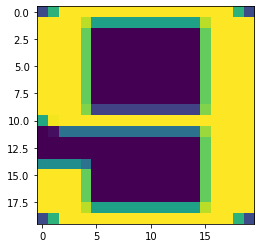

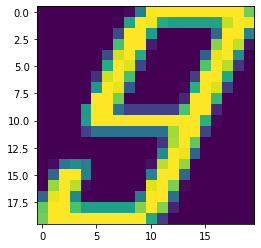

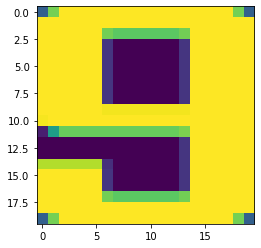

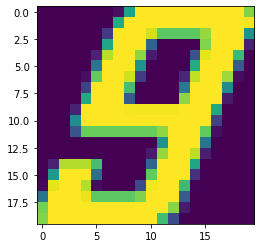

In [86]:
char_one = font_db.loc[:, 'm_label'] == 57
#chars = font_db.iloc[char_37, 12:]
chars = font_db[char_one]
for i in range(chars.shape[0]):
  chars2 = np.array(chars.iloc[i, 12:])
  chars3 = np.reshape(chars2, newshape=(20,20))
  plt.figure()
  plt.imshow(chars3.astype(float))
  plt.show()

In [26]:
chars = font_db.iloc[10,12:]
chars = np.reshape(font_db.iloc[10,12:], (20,20))
chars.shape

ValueError: ignored

In [23]:
chars[0]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 12, 136, 255, 255, 255, 255,
       255, 255], dtype=object)

In [19]:
chars[0]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 12, 136, 255, 255, 255, 255,
       255, 255], dtype=object)

In [ ]:
transform = transforms.Compose([
  transforms.ToTensor()
])

In [ ]:
folder = datasets.ImageFolder(root = directory, transform=transform)

In [ ]:
folder

Dataset ImageFolder
    Number of datapoints: 500
    Root location: gdrive/MyDrive/UNIVERSIDAD/Master Propio IA UV/3 Aprendizaje profundo (II)/Datasets/Bob Ross/train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [ ]:
batch_size = 20

folder_loader = DataLoader(folder, batch_size=batch_size, shuffle=True, num_workers=2)

In [ ]:
for batch in folder_loader:
  print(type(torch.FloatTensor(batch)))

ValueError: ignored

### Learning how the real data is displayed

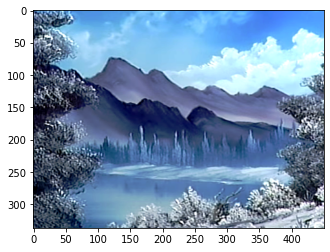

In [ ]:
#In this case, the images use the first channel for color, while it is usual to use the last channel for color
# For example, imshow uses the last channel for color
# This is the process to show one of the images from the DataLoader

# However, PyTorch's CNN works when the channesl are (image no, channel, x_size, y_size)
plt.imshow(folder[0][0].permute(1,2,0))

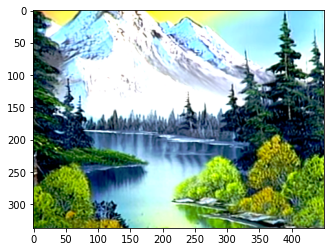

In [ ]:
#Do all the images have the same size? Or do we need to add new elements to the transform?
plt.imshow(folder[1][0].permute(1,2,0))

In [ ]:
#Let's check that all the images have the same size
[data[0].shape for data in folder]

[torch.Size([3, 337, 450]),
 torch.Size([3, 337, 450]),
 torch.Size([3, 337, 450]),
 torch.Size([3, 337, 450]),
 torch.Size([3, 337, 450]),
 torch.Size([3, 337, 450]),
 torch.Size([3, 337, 450]),
 torch.Size([3, 337, 450]),
 torch.Size([3, 337, 450]),
 torch.Size([3, 337, 450]),
 torch.Size([3, 337, 450]),
 torch.Size([3, 337, 450]),
 torch.Size([3, 337, 450]),
 torch.Size([3, 337, 450]),
 torch.Size([3, 337, 450]),
 torch.Size([3, 337, 450]),
 torch.Size([3, 337, 450]),
 torch.Size([3, 337, 450]),
 torch.Size([3, 337, 450]),
 torch.Size([3, 337, 450]),
 torch.Size([3, 337, 450]),
 torch.Size([3, 337, 450]),
 torch.Size([3, 337, 450]),
 torch.Size([3, 337, 450]),
 torch.Size([3, 337, 450]),
 torch.Size([3, 337, 450]),
 torch.Size([3, 337, 450]),
 torch.Size([3, 337, 450]),
 torch.Size([3, 337, 450]),
 torch.Size([3, 337, 450]),
 torch.Size([3, 337, 450]),
 torch.Size([3, 337, 450]),
 torch.Size([3, 337, 450]),
 torch.Size([3, 337, 450]),
 torch.Size([3, 337, 450]),
 torch.Size([3, 337,

In [ ]:
permuted_data = [data[0].permute(1,2,0) for data in folder]

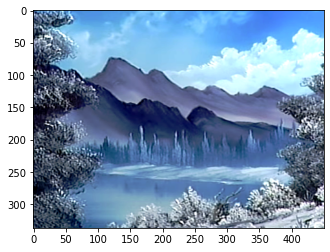

In [ ]:
plt.imshow(permuted_data[0])

In [ ]:
def train_val_dataset(dataset, val_split=0.25):
  train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split, shuffle=True)
  datasets = {}
  datasets['train'] = Subset(dataset, train_idx)
  datasets['val'] = Subset(dataset, val_idx)
  return datasets

In [ ]:
datasets = train_val_dataset(folder)

### Small experiment to check how grad works in PyTorch tensors

In [ ]:
x = torch.randn(5)
w = torch.randn(3,5).requires_grad_()
b = torch.randn(3).requires_grad_()

y = torch.randn(3)

In [ ]:
def linear(x, w, b):
  return x @ w.t() + b

def mse(pred, real):
  return (pred - real).pow(2).mean()

In [ ]:
result = linear(x, w, b)
loss = mse(result, y)

In [ ]:
loss

tensor(5.4519, grad_fn=<MeanBackward0>)

In [ ]:
loss.backward()

In [ ]:
w.grad

tensor([[ 0.9431, -0.0135, -0.7908,  0.0409,  0.9231],
        [ 1.6658, -0.0239, -1.3967,  0.0723,  1.6304],
        [ 3.4015, -0.0488, -2.8520,  0.1475,  3.3292]])

In [ ]:
w.data

tensor([[ 1.2697, -0.6939,  0.1321, -0.1466, -0.3914],
        [-1.2386, -1.8907, -1.8679, -1.9964,  0.7666],
        [ 0.6081,  0.5699,  0.1135, -0.5932,  0.5787]])

In [ ]:
w

tensor([[ 1.2697, -0.6939,  0.1321, -0.1466, -0.3914],
        [-1.2386, -1.8907, -1.8679, -1.9964,  0.7666],
        [ 0.6081,  0.5699,  0.1135, -0.5932,  0.5787]], requires_grad=True)

In [ ]:
b.data

tensor([ 0.5760,  0.7353, -1.4715])

In [ ]:
b.grad

tensor([-0.6515, -1.1507, -2.3496])

In [ ]:
a1 = torch.randn(1,3).requires_grad_()
a1.shape

torch.Size([1, 3])

In [ ]:
aa1 = a1.squeeze()
aa1.shape

torch.Size([3])

In [ ]:
a2 = torch.randn(2,3).requires_grad_()
a2.shape

torch.Size([2, 3])

In [ ]:
aa2 = a2.squeeze()
aa2.shape #The squeeze function does nothing because there is no dimension to squeeze

torch.Size([2, 3])

### Continuing with building the Bob Ross generator

In [ ]:
#Calling all the data (Bob Ross paintings) from the 
#bob_ross = [data[0].permute(1,2,0) for data in folder]
bob_ross = [data[0] for data in folder]

In [ ]:
len(bob_ross[:200])

200

In [ ]:
type(bob_ross)

list

In [ ]:
##Right now, the generator only generates one image per execution,
## maybe it should be readapted to generate a BATCH of images

class Generator(nn.Module):
  def __init__(self, noise_size, image_size):
    super(Generator, self).__init__()

    self.noise_size = noise_size
    self.hidden_channels = 10
    self.output_channels = image_size[0]
    self.hidden_size = self.hidden_channels * image_size[1] * image_size[2]

    self.linear = nn.Linear(self.noise_size, self.hidden_size)
    self.conv1 = nn.ConvTranspose2d(self.hidden_channels, self.hidden_channels//2, (3,3))
    self.conv2 = nn.ConvTranspose2d(self.hidden_channels//2, self.output_channels, (3,3))

    self.learning_rate = 0.001

    self.discriminator = None

    # Optimizer
    self.optimizer = torch.optim.Adam(self.parameters(), self.learning_rate)



  def forward(self, z):
    x = F.relu(self.linear(z))
    z = z.view(image_size, image_size, -1)
    z = F.relu(F.upsample_bilinear(self.conv1(self.conv1(z)))) ##THIS IS NOT GOING TO WORK. THE CHANNELS DON'T MATCH
    z = F.relu(F.upsample_bilinear(self.conv2(self.conv2(z))))

  # Set the reference to the DISCRIMINATOR that has been paired up with this generator
  def set_discriminator(self, discr):
    self.discriminator = discr

  # LOSS FUNCTION of the generator
  def criterion(self, z):
    return torch.log(1-discriminator.forward(self.forward(z))).sum()/z.shape[0]

  # TRAINING of the generator
  def gen_train(n_noise, n_epochs, batch_size, reset=False):

    # generate the noise that's going to be used for training
    Z = torch.randn(n_noise, noise_size)
    train_gen_data = DataLoader(Z, batch_size, shuffle=True, num_workers=2) #this code is useful to generate iterables

    for e in range(epochs):
      #iterate through all batches
      for batch in train_gen_data:
        y = self(batch)
        loss = self.criterion(y)
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()
    





In [ ]:
class Discriminator(nn.Module):
  def __init__(self, real_data, image_size):
    super(Discriminator, self).__init__()

    self.im_channels, self.im_width, self.im_height = image_size

    self.conv1_1 = nn.Conv2d(self.im_channels, 16, (3,3))
    self.conv1_2 = nn.Conv2d(16, 16, (3,3))
    self.conv2_1 = nn.Conv2d(16, 32, (3,3))
    self.conv2_2 = nn.Conv2d(32, 32, (3,3))
    self.conv3_1 = nn.Conv2d(32, 64, (3,3))
    self.conv3_2 = nn.Conv2d(64, 64, (3,3))
    self.pool = nn.MaxPool2d(kernel_size=(2,2))

    self.dense1 = nn.Linear(128, 32)
    self.dense2 = nn.Linear(32, 2)

    self.learning_rate = 0.001

    self.generator = None

    # Optimizer
    self.optimizer = torch.optim.Adam(self.parameters(), self.learning_rate)

  def forward(self, x):
    x = F.relu(self_conv1_1(x))
    x = F.relu(self_conv1_2(x))
    x = F.batch_norm(self.pool(x))
    x = F.relu(self.conv2_1(x))
    x = F.relu(self.conv2_2(x))
    x = F.batch_norm(self.pool(x))
    x = F.relu(self.conv3_1(x))
    x = F.relu(self.conv3_2(x))
    x = F.batch_norm(self.pool(x))
    x = nn.Flatten(x)
    x = F.relu(self.dense1(x))
    x = F.softmax(self.dense2(x))

  #Set the reference to the GENERATOR that has been paired up with this discriminator
  def set_generator(gen):
    self.generator = gen

  #LOSS of the discriminator
    def disc_loss(y_pred):
    #Because of the way that the discriminator has been built, the first half
    # of its entries come from real items, and the second half come from
    # the generator
      return (torch.log(y_real).sum() + torch.log(1 - y_gen).sum())/y_real.shape[0]

  #Train of the discriminator
  def discr_train(n_samples, n_epochs, batch_size, reset=False):

    #We generate the dataset that we're going to use to train
    x_gen = self.generator(torch.randn((n_samples//2, self.generator.self.noise_size)))
    #Y = torch.zeros((batch_size//2, 1))
    #Y = torch.cat((Y, torch.ones((batch_size//2, 1))), dim=0)

    #We create a dataloader that fits our needs
    data_real = random_shuffle(real_data)
    data_real = data_real[:n_samples//2]
    image_loader = DataLoader(data_real, batch_size=batch_size//2, shuffle=True, num_workers=2)

    #Training loop
    for epoch in range(n_epochs):
      for x_real in image_loader:
        #batch = torch.cat((batch, X_gen))
        y_real = self(x_real)
        y_gen = self(x_gen)
        #y_pred = self(batch)
        loss = disc_loss(y_real, y_gen)
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()


In [ ]:
class Gen_Wrapper():
  def __init__(self, generator):

    self.generator = generator
    self discriminator = None

    # Generator loss function


In [ ]:
gen = Generator(200, bob_ross[0].shape)
disc = Discriminator(bob_ross, bob_ross[0].shape)

In [ ]:
gen

Generator(
  (linear): Linear(in_features=200, out_features=1516500, bias=True)
  (conv1): ConvTranspose2d(10, 5, kernel_size=(3, 3), stride=(1, 1))
  (conv2): ConvTranspose2d(5, 3, kernel_size=(3, 3), stride=(1, 1))
)

In [ ]:
disc

Discriminator(
  (conv1_1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv1_2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2_1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (dense1): Linear(in_features=128, out_features=32, bias=True)
  (dense2): Linear(in_features=32, out_features=2, bias=True)
)

In [ ]:
x = torch.randn(5, 32, 32, 3)
m = F.avg_pool2d(kernel_size=)
y = F.avg_pool2d(x)
y.shape

TypeError: ignored

In [ ]:
n_noise = 100
noise_size = 3
batch_size = 2

Z = Z = torch.randn(n_noise, noise_size)
train_gen_data = DataLoader(Z, batch_size, shuffle=True, num_workers=2)

In [ ]:
for data in train_gen_data:
  print(data)
  print('hello')

tensor([[ 1.1432, -0.6276, -0.9969],
        [ 0.0494, -0.6551,  1.4254]])
hello
tensor([[-1.0565,  0.1588, -0.2860],
        [ 0.2134,  0.3671,  0.2513]])
hello
tensor([[ 2.0495, -1.4641, -0.9266],
        [ 0.1609,  0.3143,  0.7446]])
hello
tensor([[ 1.5117, -1.0308, -0.6375],
        [-0.8454, -0.3034,  1.1299]])
hello
tensor([[-0.3528,  0.6613, -0.0638],
        [ 0.4955, -0.1741, -0.6801]])
hello
tensor([[-0.2835,  1.5443, -0.4452],
        [-1.6577, -0.3096, -0.3955]])
hello
tensor([[-1.2681,  3.9732, -1.8714],
        [-1.1014,  0.9171, -0.6988]])
hello
tensor([[ 0.0517,  0.3341, -1.1989],
        [-1.0194,  0.0229, -0.8954]])
hello
tensor([[-0.5301,  0.1027,  1.3803],
        [-0.0057, -0.9863, -0.1489]])
hello
tensor([[-1.5719, -0.5399, -0.6251],
        [ 1.3910,  0.3542,  0.4601]])
hello
tensor([[ 0.5968, -0.5150,  0.2246],
        [ 0.0505, -0.0546, -1.1739]])
hello
tensor([[ 1.6030, -1.1565,  0.9535],
        [-1.2447,  0.7533,  0.4049]])
hello
tensor([[ 0.2255, -0.7892,  

In [ ]:
a = torch.randn((10, 3, 15, 15))
b = [torch.randn((15,15,3)) for i in range(10)]
c = torch.randn((1, 15, 15, 3))
#model = torch.nn.Sequential([
#                             torch.nn.input()
#])
m = torch.nn.Conv2d(3, 5, kernel_size=(3,3))
y = m(b)

TypeError: ignored

In [ ]:
#Si yo a un dataloader le paso un torch.tensor, me lo trocea y me
# devuelve un torch.tensor para cada batch
loader = DataLoader(a, batch_size=2, shuffle=True)
for data in loader:
  print(data.shape)

torch.Size([2, 3, 15, 15])
torch.Size([2, 3, 15, 15])
torch.Size([2, 3, 15, 15])
torch.Size([2, 3, 15, 15])
torch.Size([2, 3, 15, 15])


In [ ]:
#Y si le paso una lista: me devuelve también un torch.tesnor! Eso es genial!
loader = DataLoader(b, batch_size=2, shuffle=True)
for data in loader:
  print(data.shape)

torch.Size([2, 15, 15, 3])
torch.Size([2, 15, 15, 3])
torch.Size([2, 15, 15, 3])
torch.Size([2, 15, 15, 3])
torch.Size([2, 15, 15, 3])
